# Data Generation

In [1]:
import pickle
ticker_timeseries = pickle.load(open("cache/ticker_timeseries.pkl", "rb"))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
from datetime import timedelta

# ---------- params ----------
lookback_window = 4
eps = 1e-8  # to avoid log(0)
api_key = '7JIMRNYIWH5MTWOF'  # Replace with your actual API key
lag_days = 7

# ---------- Stock Price Data Collection ----------
def get_stock_price_data(symbol, api_key, outputsize='full'):
    """
    Fetch daily OHLC stock price data from Alpha Vantage API
    """
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&outputsize={outputsize}'
    
    try:
        r = requests.get(url)
        data = r.json()
        
        if 'Time Series (Daily)' not in data:
            print(f"No price data found or API limit reached. Keys in response: {list(data.keys())}")
            return pd.DataFrame()
        
        # Convert to DataFrame
        price_data = data['Time Series (Daily)']
        df = pd.DataFrame.from_dict(price_data, orient='index')
        df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Convert to numeric and sort by date
        for col in df.columns:
            df[col] = pd.to_numeric(df[col])
        
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        
        return df[['Open', 'High', 'Low', 'Close']]  # Only OHLC
        
    except Exception as e:
        print(f"Error fetching price data: {e}")
        return pd.DataFrame()

def create_price_features(si_dates, price_data, gap_days=15):
    """
    Create daily OHLC price features for each SI date with 7-day lag structure
    Features: [day1_open, day1_high, day1_low, day1_close, ..., day7_open, day7_high, day7_low, day7_close]
    Total: 4 * 7 = 28 features
    """
    if price_data.empty:
        print("No price data available, creating zero features")
        return np.zeros((len(si_dates), 28))  # 4*7 = 28 features
    
    price_features = []
    
    for si_date in si_dates:
        si_datetime = pd.to_datetime(si_date)

        # Define the 14-day window (gap_days before the SI date)
        window_end = si_datetime - timedelta(days=1)  # Day before SI date
        
        features = []

        # Get price data for each of the 15 days
        for day_offset in range(gap_days):
            target_date = window_end - timedelta(days=day_offset)
            
            # Find the closest trading day (in case of weekends/holidays)
            closest_date = None
            min_diff = timedelta(days=10)  # Max search window
            
            for price_date in price_data.index:
                diff = abs(price_date.date() - target_date.date())
                if diff < min_diff:
                    min_diff = diff
                    closest_date = price_date
            
            if closest_date is not None and min_diff <= timedelta(days=3):  # Within 3 days
                day_data = price_data.loc[closest_date]
                features.extend([
                    day_data['Open'],
                    day_data['High'], 
                    day_data['Low'],
                    day_data['Close']
                ])
            else:
                # No data available, use NaNs
                features.extend([np.nan, np.nan, np.nan, np.nan])
        
        price_features.append(features)
    price_features = np.array(price_features)
    # Handle NaNs by imputing with column means
    col_means = np.nanmean(price_features, axis=0)
    price_features = np.where(np.isnan(price_features), col_means, price_features)

    return price_features

In [12]:
# ---------- data ----------
# raw levels (T, 2)
stock = 'PFE'
gap_days = 15
si_dates = ticker_timeseries[stock]['SI'].dropna().index

SI_series = ticker_timeseries[stock]['SI'].dropna().values.astype(np.float64).reshape(-1, 1)
vol_series = ticker_timeseries[stock]['Volume'].dropna().values.astype(np.float64).reshape(-1, 1)

# Fetch stock price data
print(f"Fetching {stock} price data...")
price_data = get_stock_price_data(stock, api_key)
print(f"Retrieved price data for {len(price_data)} trading days")
if not price_data.empty:
    print(f"Price data date range: {price_data.index.min()} to {price_data.index.max()}")

# Create price features
print("Creating price features...")
price_features = create_price_features(si_dates, price_data, gap_days)
print(f"Price features shape: {price_features.shape}")

# Combine all features: [SI, Volume, 60 price features]
level_series = np.concatenate([SI_series, vol_series, price_features], axis=1)  # (T, 62)
print(f"Combined features shape: {level_series.shape}")


Fetching PFE price data...
Retrieved price data for 6505 trading days
Price data date range: 1999-11-01 00:00:00 to 2025-09-11 00:00:00
Creating price features...
Price features shape: (182, 60)
Combined features shape: (182, 62)


In [13]:
# log of SI levels (T,) for the target
series_safe = np.where(SI_series <= 0, eps, SI_series).reshape(-1)
y_log = np.log(series_safe)

# build supervised windows with log-return target
def make_windows_level_to_logret(level_series, y_log, lookback):
    X_list, y_logret_list, prev_log_list = [], [], []
    for t in range(lookback, len(level_series)):
        X_list.append(level_series[t - lookback:t, :])                  # (L, 62)
        y_logret_list.append([y_log[t] - y_log[t - 1]])                 # (1,)
        prev_log_list.append(y_log[t - 1])   
    X = np.asarray(X_list)                          # (N, L, 62)
    y_logret = np.asarray(y_logret_list)            # (N, 1)
    prev_log = np.asarray(prev_log_list)            # (N,)
    return X, y_logret, prev_log

X_raw, y_logret, prev_log_all = make_windows_level_to_logret(level_series, y_log, lookback_window)

# ---------- split ----------
N = X_raw.shape[0]
split = int(0.8 * N)
X_train_raw, X_test_raw = X_raw[:split], X_raw[split:]
y_train, y_test = y_logret[:split], y_logret[split:]
prev_log_train, prev_log_test = prev_log_all[:split], prev_log_all[split:]

In [14]:
# Prepare data dictionary with all relevant training and test data
data_to_save = {
    # Raw data
    'X_train_raw': X_train_raw,
    'X_test_raw': X_test_raw,
    'y_train': y_train,
    'y_test': y_test,
    
    # Dates
    'si_dates': si_dates,
    'SI_series': SI_series,

    'prev_log_test': prev_log_test,
    'prev_log_train': prev_log_train
}

# Save to pickle file
filename = f'cache/{stock}_raw_data_with_ohlc.pkl'
with open(filename, 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"Training and test data saved to: {filename}")


Training and test data saved to: cache/PFE_raw_data_with_ohlc.pkl


# Train without Feature Selection

In [9]:
import pickle
stock = 'PFE'
ticker_timeseries = pickle.load(open("cache/ticker_timeseries.pkl", "rb"))
raw_data = pickle.load(open(f'cache/{stock}_raw_data_with_ohlc.pkl', 'rb'))
X_train_raw = raw_data['X_train_raw']
X_test_raw = raw_data['X_test_raw']
y_train = raw_data['y_train']
y_test = raw_data['y_test']
prev_log_train = raw_data['prev_log_train']
prev_log_test = raw_data['prev_log_test']
si_dates = raw_data['si_dates']
SI_series = raw_data['SI_series']

split = X_train_raw.shape[0]
lookback_window = X_train_raw.shape[1]


Model input size: 62
Training data shape: (142, 4, 62)
Epoch 1/80, Train Loss: 0.016380
Epoch 11/80, Train Loss: 0.013966
Epoch 21/80, Train Loss: 0.013260
Epoch 31/80, Train Loss: 0.013034
Epoch 41/80, Train Loss: 0.012654
Epoch 51/80, Train Loss: 0.009787
Epoch 61/80, Train Loss: 0.011826
Epoch 71/80, Train Loss: 0.007438
Early stopping at epoch 77

Model Performance:
MAE: 9791838.0330
RMSE: 12627845.0596
MAPE: 11.09%


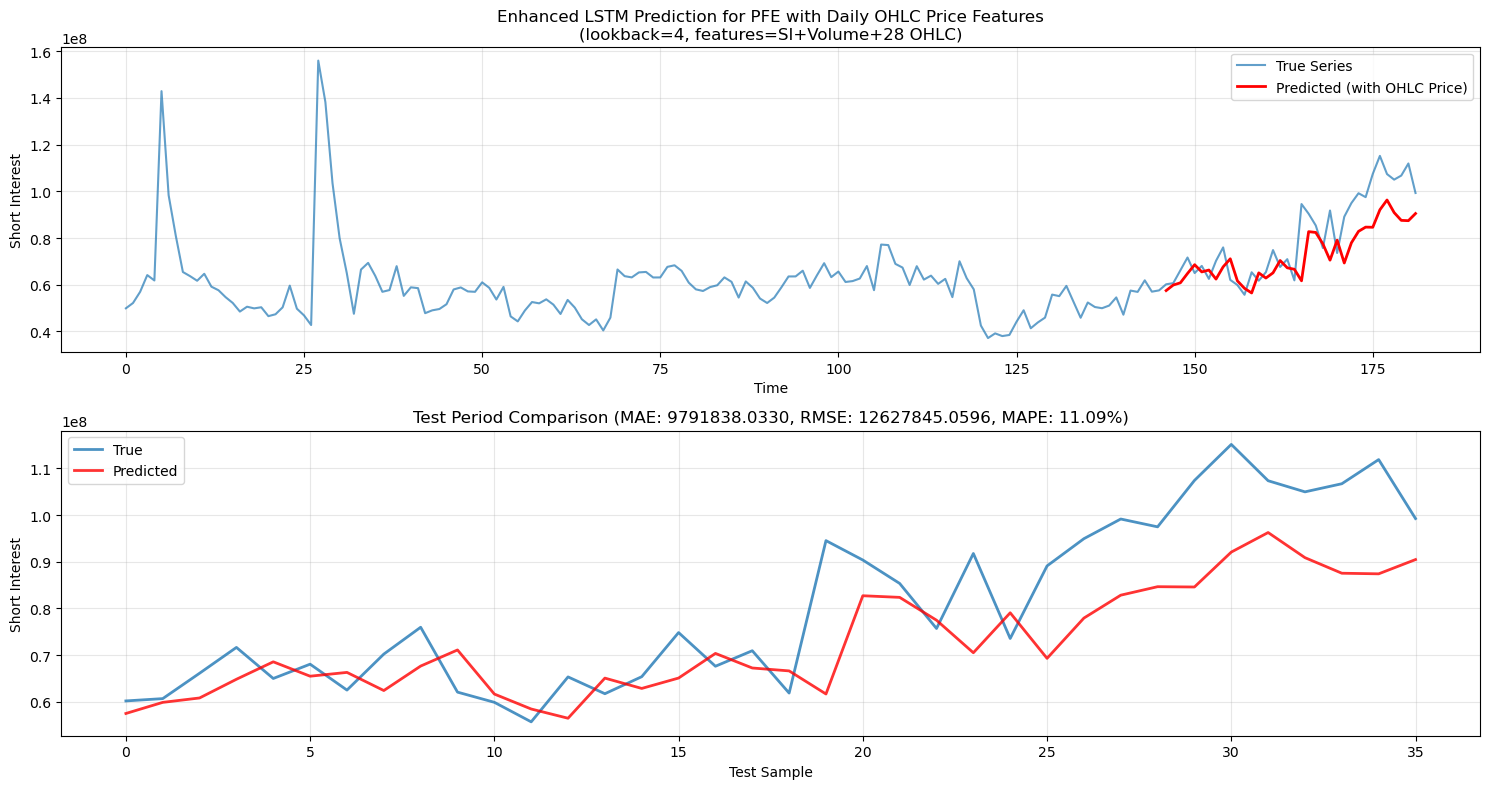

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

# ---------- scale inputs ONLY (per-feature, fit on train) ----------
# Reshape for scaling: (N*L, features) -> scale -> reshape back
scaler = StandardScaler()
X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[-1])
scaler.fit(X_train_reshaped)

X_train = scaler.transform(X_train_reshaped).reshape(X_train_raw.shape)
X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[-1])
X_test = scaler.transform(X_test_reshaped).reshape(X_test_raw.shape)

# ---------- tensors / loaders ----------
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

batch_size = 8
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size)

# ---------- enhanced model (predicts log-return) ----------
class EnhancedLSTMTimeSeries(nn.Module):
    def __init__(self, input_size=30, hidden_size=64, num_layers=3, output_size=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Take the last time step output
        last_output = lstm_out[:, -1, :]
        
        # Feed through fully connected layers
        out = self.dropout(last_output)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Updated model with more capacity for additional features
model = EnhancedLSTMTimeSeries(input_size=62, hidden_size=64, num_layers=3, output_size=1)
criterion = nn.SmoothL1Loss()         # Huber; more robust than MSE
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

print(f"Model input size: {62}")
print(f"Training data shape: {X_train.shape}")

# ---------- training ----------
epochs = 80
best_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)               # predicts Δlog
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Early stopping
    if train_loss < best_loss:
        best_loss = train_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# ---------- evaluation: predict log-returns and reconstruct levels ----------
model.eval()
pred_logret = []
with torch.no_grad():
    for xb, _ in test_loader:
        pred_logret.append(model(xb).numpy())
pred_logret = np.concatenate(pred_logret, axis=0).ravel()     # (N_test,)

# reconstruct levels: ŷ_t = exp(prev_log_t + r̂_t)
y_pred_levels = np.exp(prev_log_test + pred_logret)

# true levels aligned with the targets (these are y_t for the test windows)
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# Calculate metrics
mae = np.mean(np.abs(y_pred_levels - y_true_levels))
rmse = np.sqrt(np.mean((y_pred_levels - y_true_levels)**2))
mape = np.mean(np.abs((y_true_levels - y_pred_levels) / y_true_levels)) * 100

print(f"\nModel Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# ---------- plot ----------
plt.figure(figsize=(15, 8))

# Plot full series
plt.subplot(2, 1, 1)
plt.plot(range(len(SI_series)), SI_series.reshape(-1), label='True Series', linewidth=1.5, alpha=0.7)
start = split + lookback_window
end = start + len(y_pred_levels)
plt.plot(range(start, end), y_pred_levels, label='Predicted (with OHLC Price)', color='red', linewidth=2)
plt.title(f'Enhanced LSTM Prediction for {stock} with Daily OHLC Price Features\n(lookback={lookback_window}, features=SI+Volume+28 OHLC)')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot test period only
plt.subplot(2, 1, 2)
test_range = range(len(y_true_levels))
plt.plot(test_range, y_true_levels, label='True', linewidth=2, alpha=0.8)
plt.plot(test_range, y_pred_levels, label='Predicted', color='red', linewidth=2, alpha=0.8)
plt.title(f'Test Period Comparison (MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%)')
plt.xlabel('Test Sample')
plt.ylabel('Short Interest')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Flattened training data shape: (142, 248)
Flattened test data shape: (36, 248)
Feature dimension per sample: 248 (lookback=4 × features=30)
Features: SI + Volume + 28 daily OHLC price features (4 OHLC × 7 days)
Training SVM...
Training Linear Regression...
Training 2-layer MLP...
MLP Epoch 1/100, Loss: 0.106578
MLP Epoch 21/100, Loss: 0.024559
MLP Epoch 41/100, Loss: 0.019575
MLP Epoch 61/100, Loss: 0.017414
MLP Epoch 81/100, Loss: 0.015728


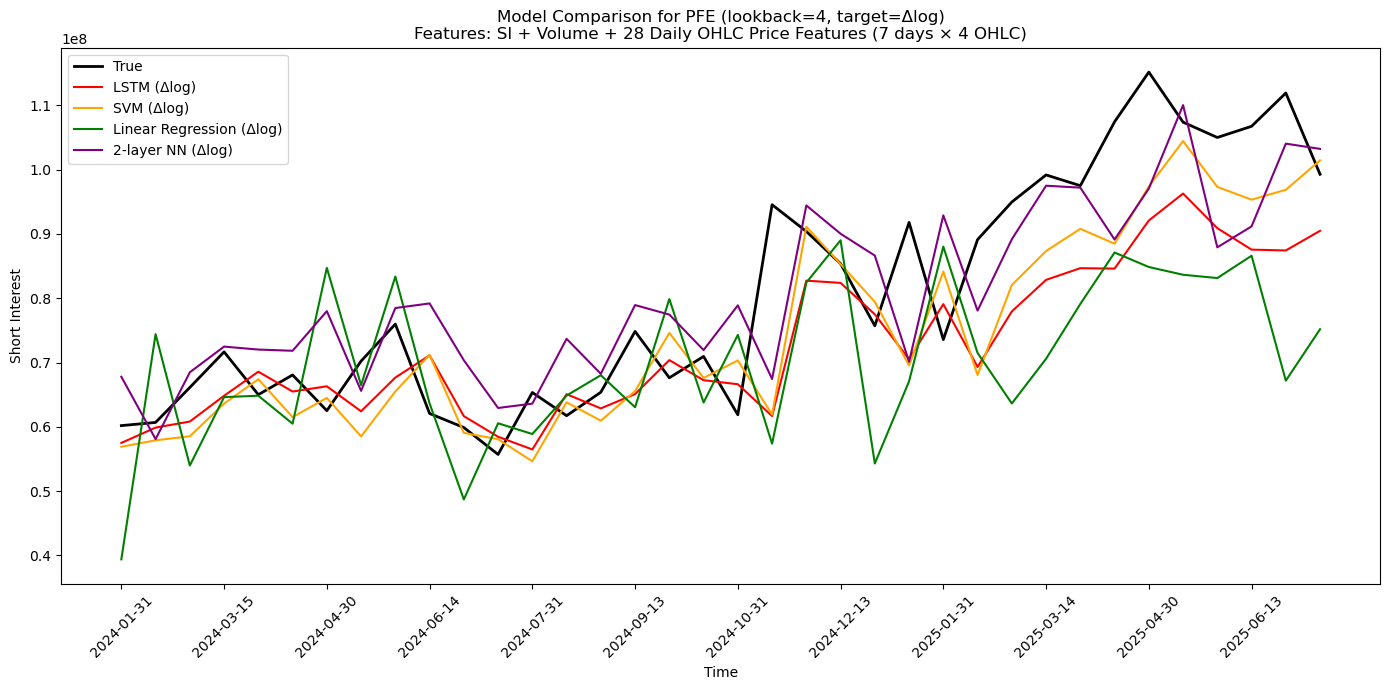


MODEL PERFORMANCE COMPARISON WITH OHLC FEATURES
            Model          MAE    MAPE         RMSE
              SVM 8.637166e+06 10.3377 1.114692e+07
             LSTM 9.791838e+06 11.0909 1.262785e+07
       2-layer NN 8.892132e+06 11.2884 1.129132e+07
Linear Regression 1.551961e+07 18.3124 1.877057e+07

Best performing model: SVM (MAPE: 10.34%)
LSTM rank: 1 out of 4
SVM vs Linear Regression: 43.5% improvement
LSTM vs Linear Regression: 39.4% improvement
2-layer NN vs Linear Regression: 38.4% improvement


In [10]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# -------------------------------------------------
# Assumes these already exist from your Δlog pipeline:
# X_train, X_test                # scaled inputs (N,L,30) windows
# y_train, y_test                # targets = Δlog(y) with shape (N,1)
# prev_log_test                  # np.array of log(y_{t-1}) for each X_test row, shape (N,)
# y_pred_levels (from LSTM)      # optional, if you already computed it
# SI_series                      # original level series (T,1)
# split, lookback_window         # same as before
# dates                          # index for plotting (use the SI series index)
# -------------------------------------------------



# Flatten inputs for sklearn (from 3D to 2D)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # (N, lookback * 30)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)    # (N_test, lookback * 30)

print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened test data shape: {X_test_flat.shape}")
print(f"Feature dimension per sample: {X_train_flat.shape[1]} (lookback={lookback_window} × features=30)")
print("Features: SI + Volume + 28 daily OHLC price features (4 OHLC × 7 days)")

# ---- SVM predicts Δlog ----
print("Training SVM...")
svm = SVR()
svm.fit(X_train_flat, y_train.ravel())
svm_logret  = svm.predict(X_test_flat)                 # r̂_t
svm_levels  = np.exp(prev_log_test + svm_logret)       # ŷ_t

# ---- Linear Regression predicts Δlog ----
print("Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_flat, y_train.ravel())
lr_logret   = lr.predict(X_test_flat)
lr_levels   = np.exp(prev_log_test + lr_logret)

# ---- 2-layer MLP predicts Δlog ----
print("Training 2-layer MLP...")

# Define a simple 2-layer NN for regression
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=32, hidden_dim2=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_torch = SimpleMLP(X_train_flat.shape[1])
optimizer_mlp = torch.optim.Adam(mlp_torch.parameters(), lr=1e-3)
criterion_mlp = nn.SmoothL1Loss()

X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.ravel(), dtype=torch.float32).unsqueeze(1)
X_test_tensor  = torch.tensor(X_test_flat, dtype=torch.float32)

# Train the model
epochs_mlp = 100
for epoch in range(epochs_mlp):
    mlp_torch.train()
    optimizer_mlp.zero_grad()
    output = mlp_torch(X_train_tensor)
    loss = criterion_mlp(output, y_train_tensor)
    loss.backward()
    optimizer_mlp.step()
    
    if epoch % 20 == 0:
        print(f"MLP Epoch {epoch+1}/{epochs_mlp}, Loss: {loss.item():.6f}")

# Predict
mlp_torch.eval()
with torch.no_grad():
    mlp_logret = mlp_torch(X_test_tensor).detach().numpy().ravel()
mlp_levels = np.exp(prev_log_test + mlp_logret)

# ---- LSTM levels (from your earlier step) ----
lstm_levels = y_pred_levels  # keep your variable name

# ---- True levels aligned to the test targets ----
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# ---- Plot test period only ----
dates = ticker_timeseries[stock]['SI'].dropna().index  # for x-ticks
plt.figure(figsize=(14,7))
test_idx = range(split + lookback_window, split + lookback_window + len(y_true_levels))
plt.plot(test_idx, y_true_levels, label='True', color='black', linewidth=2)
plt.plot(test_idx, lstm_levels, label='LSTM (Δlog)', color='red')
plt.plot(test_idx, svm_levels,  label='SVM (Δlog)', color='orange')
plt.plot(test_idx, lr_levels,   label='Linear Regression (Δlog)', color='green')
plt.plot(test_idx, mlp_levels,  label='2-layer NN (Δlog)', color='purple')

# Format x-axis with actual dates
if len(test_idx) <= 20:  # Only show date labels if not too many points
    plt.xticks(
        ticks=test_idx,
        labels=pd.Index(dates)[split+lookback_window:split+lookback_window+len(y_true_levels)].strftime('%Y-%m-%d'),
        rotation=45
    )
else:
    # Show fewer date labels for better readability
    step = len(test_idx) // 10
    selected_idx = test_idx[::step]
    plt.xticks(
        ticks=selected_idx,
        labels=pd.Index(dates)[split+lookback_window:split+lookback_window+len(y_true_levels)][::step].strftime('%Y-%m-%d'),
        rotation=45
    )

plt.title(f'Model Comparison for {stock} (lookback={lookback_window}, target=Δlog)\nFeatures: SI + Volume + 28 Daily OHLC Price Features (7 days × 4 OHLC)')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Metrics on ORIGINAL LEVELS ----
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, mape, rmse

results = []
for name, pred in [ 
    ("LSTM", lstm_levels),
    ("SVM", svm_levels),
    ("Linear Regression", lr_levels),
    ("2-layer NN", mlp_levels),
]:
    mae, mape, rmse = get_metrics(y_true_levels, pred)
    results.append({"Model": name, "MAE": mae, "MAPE": mape*100, "RMSE": rmse})

results_df = pd.DataFrame(results)
# Sort by MAPE (lower is better)
results_df = results_df.sort_values('MAPE')

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON WITH OHLC FEATURES")
print("="*60)
print(results_df.round(4).to_string(index=False))

# ---- Additional Analysis ----
print(f"\nBest performing model: {results_df.iloc[0]['Model']} (MAPE: {results_df.iloc[0]['MAPE']:.2f}%)")
print(f"LSTM rank: {results_df[results_df['Model'] == 'LSTM'].index[0] + 1} out of {len(results_df)}")

# Show improvement over linear baseline
lr_mape = results_df[results_df['Model'] == 'Linear Regression']['MAPE'].iloc[0]
for _, row in results_df.iterrows():
    if row['Model'] != 'Linear Regression':
        improvement = ((lr_mape - row['MAPE']) / lr_mape) * 100
        print(f"{row['Model']} vs Linear Regression: {improvement:.1f}% {'improvement' if improvement > 0 else 'worse'}")


# With Selected Features

In [11]:
import pickle
stock = 'PFE'
selected_data = pickle.load(open(f'cache/{stock}_data_selected.pkl', 'rb'))
raw_data = pickle.load(open(f'cache/{stock}_raw_data_with_ohlc.pkl', 'rb'))

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

Model input size: 15
Training data shape: (142, 4, 15)
Epoch 1/80, Train Loss: 0.016007
Epoch 11/80, Train Loss: 0.013667
Epoch 21/80, Train Loss: 0.012976
Epoch 31/80, Train Loss: 0.011397
Epoch 41/80, Train Loss: 0.010074
Epoch 51/80, Train Loss: 0.006968
Epoch 61/80, Train Loss: 0.003575
Epoch 71/80, Train Loss: 0.005496
Early stopping at epoch 71

Model Performance:
MAE: 8033999.9155
RMSE: 10485727.0149
MAPE: 10.06%


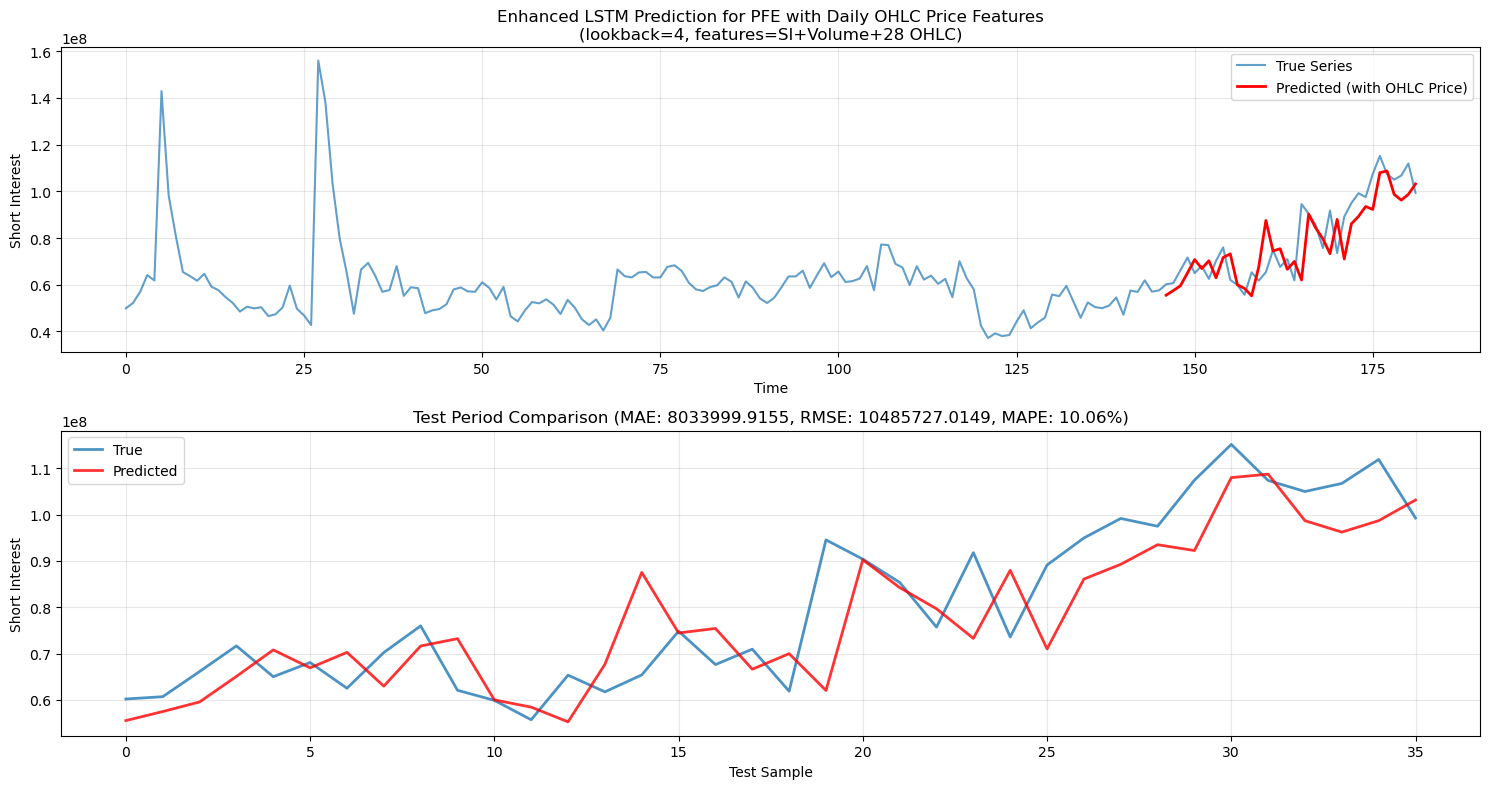

In [13]:
X_train_raw = selected_data['X_train_selected']
X_test_raw = selected_data['X_test_selected']
y_train = selected_data['y_train']
y_test = selected_data['y_test']

SI_series = raw_data['SI_series']
prev_log_test = raw_data['prev_log_test']
split = X_train_raw.shape[0]
lookback_window = X_train_raw.shape[1]

# ---------- scale inputs ONLY (per-feature, fit on train) ----------
# Reshape for scaling: (N*L, features) -> scale -> reshape back
scaler = StandardScaler()
X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[-1])
scaler.fit(X_train_reshaped)

X_train = scaler.transform(X_train_reshaped).reshape(X_train_raw.shape)
X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[-1])
X_test = scaler.transform(X_test_reshaped).reshape(X_test_raw.shape)

# ---------- tensors / loaders ----------
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

batch_size = 8
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size)

# ---------- enhanced model (predicts log-return) ----------
class EnhancedLSTMTimeSeries(nn.Module):
    def __init__(self, input_size=30, hidden_size=64, num_layers=3, output_size=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Take the last time step output
        last_output = lstm_out[:, -1, :]
        
        # Feed through fully connected layers
        out = self.dropout(last_output)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Updated model with more capacity for additional features
model_input_size = X_train_raw.shape[-1]
model = EnhancedLSTMTimeSeries(input_size=model_input_size, hidden_size=32, num_layers=3, output_size=1)
criterion = nn.SmoothL1Loss()         # Huber; more robust than MSE
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

print(f"Model input size: {model_input_size}")
print(f"Training data shape: {X_train.shape}")

# ---------- training ----------
epochs = 80
best_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)               # predicts Δlog
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Early stopping
    if train_loss < best_loss:
        best_loss = train_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# ---------- evaluation: predict log-returns and reconstruct levels ----------
model.eval()
pred_logret = []
with torch.no_grad():
    for xb, _ in test_loader:
        pred_logret.append(model(xb).numpy())
pred_logret = np.concatenate(pred_logret, axis=0).ravel()     # (N_test,)

# reconstruct levels: ŷ_t = exp(prev_log_t + r̂_t)
y_pred_levels = np.exp(prev_log_test + pred_logret)

# true levels aligned with the targets (these are y_t for the test windows)
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# Calculate metrics
mae = np.mean(np.abs(y_pred_levels - y_true_levels))
rmse = np.sqrt(np.mean((y_pred_levels - y_true_levels)**2))
mape = np.mean(np.abs((y_true_levels - y_pred_levels) / y_true_levels)) * 100

print(f"\nModel Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# ---------- plot ----------
plt.figure(figsize=(15, 8))

# Plot full series
plt.subplot(2, 1, 1)
plt.plot(range(len(SI_series)), SI_series.reshape(-1), label='True Series', linewidth=1.5, alpha=0.7)
start = split + lookback_window
end = start + len(y_pred_levels)
plt.plot(range(start, end), y_pred_levels, label='Predicted (with OHLC Price)', color='red', linewidth=2)
plt.title(f'Enhanced LSTM Prediction for {stock} with Daily OHLC Price Features\n(lookback={lookback_window}, features=SI+Volume+28 OHLC)')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot test period only
plt.subplot(2, 1, 2)
test_range = range(len(y_true_levels))
plt.plot(test_range, y_true_levels, label='True', linewidth=2, alpha=0.8)
plt.plot(test_range, y_pred_levels, label='Predicted', color='red', linewidth=2, alpha=0.8)
plt.title(f'Test Period Comparison (MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%)')
plt.xlabel('Test Sample')
plt.ylabel('Short Interest')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Flattened training data shape: (142, 60)
Flattened test data shape: (36, 60)
Feature dimension per sample: 60 (lookback=4 × features=30)
Features: SI + Volume + 28 daily OHLC price features (4 OHLC × 7 days)
Training SVM...
Training Linear Regression...
Training 2-layer MLP...
MLP Epoch 1/100, Loss: 0.020082
MLP Epoch 21/100, Loss: 0.011541
MLP Epoch 41/100, Loss: 0.008639
MLP Epoch 61/100, Loss: 0.005965
MLP Epoch 81/100, Loss: 0.003142


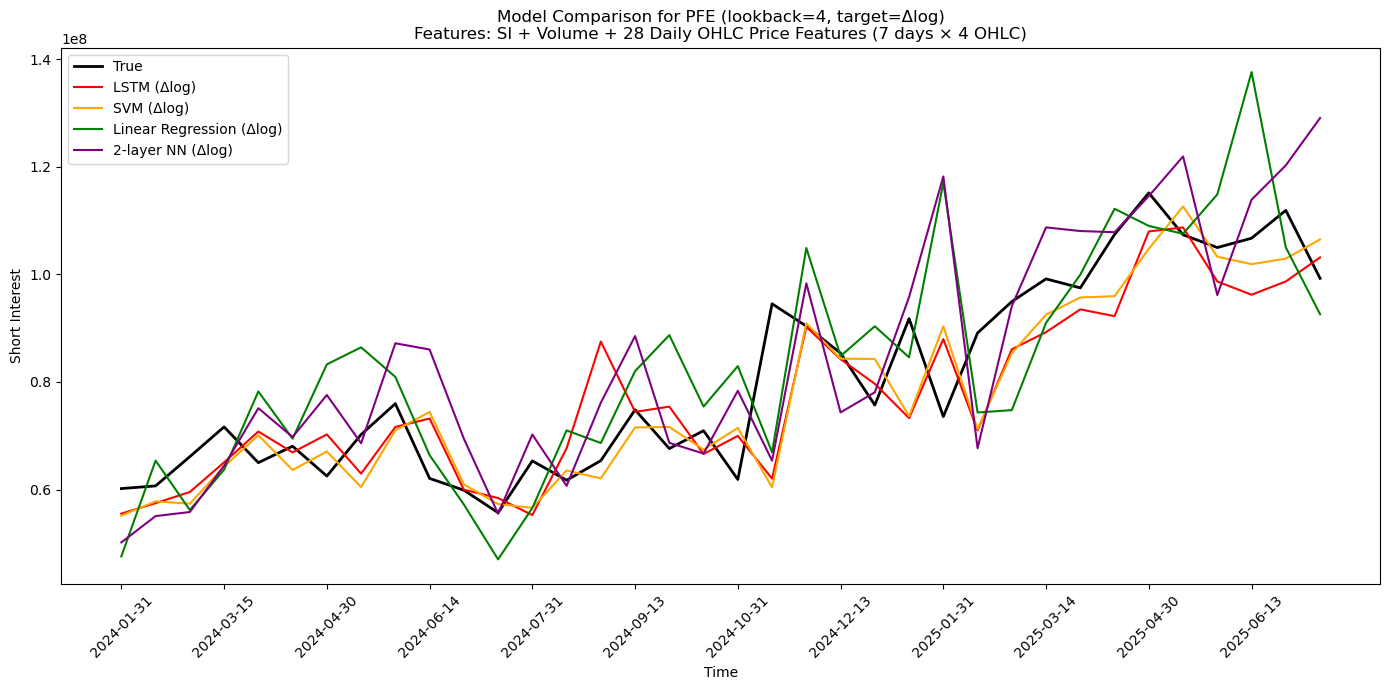


MODEL PERFORMANCE COMPARISON WITH OHLC FEATURES
            Model          MAE    MAPE         RMSE
              SVM 7.418909e+06  9.2214 9.810425e+06
             LSTM 8.034000e+06 10.0602 1.048573e+07
       2-layer NN 1.028403e+07 13.2580 1.399674e+07
Linear Regression 1.115680e+07 14.5480 1.444242e+07

Best performing model: SVM (MAPE: 9.22%)
LSTM rank: 1 out of 4
SVM vs Linear Regression: 36.6% improvement
LSTM vs Linear Regression: 30.8% improvement
2-layer NN vs Linear Regression: 8.9% improvement


In [14]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# -------------------------------------------------
# Assumes these already exist from your Δlog pipeline:
# X_train, X_test                # scaled inputs (N,L,30) windows
# y_train, y_test                # targets = Δlog(y) with shape (N,1)
# prev_log_test                  # np.array of log(y_{t-1}) for each X_test row, shape (N,)
# y_pred_levels (from LSTM)      # optional, if you already computed it
# SI_series                      # original level series (T,1)
# split, lookback_window         # same as before
# dates                          # index for plotting (use the SI series index)
# -------------------------------------------------

# Flatten inputs for sklearn (from 3D to 2D)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # (N, lookback * 30)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)    # (N_test, lookback * 30)

print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened test data shape: {X_test_flat.shape}")
print(f"Feature dimension per sample: {X_train_flat.shape[1]} (lookback={lookback_window} × features=30)")
print("Features: SI + Volume + 28 daily OHLC price features (4 OHLC × 7 days)")

# ---- SVM predicts Δlog ----
print("Training SVM...")
svm = SVR()
svm.fit(X_train_flat, y_train.ravel())
svm_logret  = svm.predict(X_test_flat)                 # r̂_t
svm_levels  = np.exp(prev_log_test + svm_logret)       # ŷ_t

# ---- Linear Regression predicts Δlog ----
print("Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_flat, y_train.ravel())
lr_logret   = lr.predict(X_test_flat)
lr_levels   = np.exp(prev_log_test + lr_logret)

# ---- 2-layer MLP predicts Δlog ----
print("Training 2-layer MLP...")

# Define a simple 2-layer NN for regression
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=32, hidden_dim2=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_torch = SimpleMLP(X_train_flat.shape[1])
optimizer_mlp = torch.optim.Adam(mlp_torch.parameters(), lr=1e-3)
criterion_mlp = nn.SmoothL1Loss()

X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.ravel(), dtype=torch.float32).unsqueeze(1)
X_test_tensor  = torch.tensor(X_test_flat, dtype=torch.float32)

# Train the model
epochs_mlp = 100
for epoch in range(epochs_mlp):
    mlp_torch.train()
    optimizer_mlp.zero_grad()
    output = mlp_torch(X_train_tensor)
    loss = criterion_mlp(output, y_train_tensor)
    loss.backward()
    optimizer_mlp.step()
    
    if epoch % 20 == 0:
        print(f"MLP Epoch {epoch+1}/{epochs_mlp}, Loss: {loss.item():.6f}")

# Predict
mlp_torch.eval()
with torch.no_grad():
    mlp_logret = mlp_torch(X_test_tensor).detach().numpy().ravel()
mlp_levels = np.exp(prev_log_test + mlp_logret)

# ---- LSTM levels (from your earlier step) ----
lstm_levels = y_pred_levels  # keep your variable name

# ---- True levels aligned to the test targets ----
y_true_levels = np.exp(prev_log_test + y_test.ravel())

# ---- Plot test period only ----
dates = raw_data['si_dates']  # for x-ticks
plt.figure(figsize=(14,7))
test_idx = range(split + lookback_window, split + lookback_window + len(y_true_levels))
plt.plot(test_idx, y_true_levels, label='True', color='black', linewidth=2)
plt.plot(test_idx, lstm_levels, label='LSTM (Δlog)', color='red')
plt.plot(test_idx, svm_levels,  label='SVM (Δlog)', color='orange')
plt.plot(test_idx, lr_levels,   label='Linear Regression (Δlog)', color='green')
plt.plot(test_idx, mlp_levels,  label='2-layer NN (Δlog)', color='purple')

# Format x-axis with actual dates
if len(test_idx) <= 20:  # Only show date labels if not too many points
    plt.xticks(
        ticks=test_idx,
        labels=pd.Index(dates)[split+lookback_window:split+lookback_window+len(y_true_levels)].strftime('%Y-%m-%d'),
        rotation=45
    )
else:
    # Show fewer date labels for better readability
    step = len(test_idx) // 10
    selected_idx = test_idx[::step]
    plt.xticks(
        ticks=selected_idx,
        labels=pd.Index(dates)[split+lookback_window:split+lookback_window+len(y_true_levels)][::step].strftime('%Y-%m-%d'),
        rotation=45
    )

plt.title(f'Model Comparison for {stock} (lookback={lookback_window}, target=Δlog)\nFeatures: SI + Volume + 28 Daily OHLC Price Features (7 days × 4 OHLC)')
plt.xlabel('Time')
plt.ylabel('Short Interest')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Metrics on ORIGINAL LEVELS ----
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, mape, rmse

results = []
for name, pred in [ 
    ("LSTM", lstm_levels),
    ("SVM", svm_levels),
    ("Linear Regression", lr_levels),
    ("2-layer NN", mlp_levels),
]:
    mae, mape, rmse = get_metrics(y_true_levels, pred)
    results.append({"Model": name, "MAE": mae, "MAPE": mape*100, "RMSE": rmse})

results_df = pd.DataFrame(results)
# Sort by MAPE (lower is better)
results_df = results_df.sort_values('MAPE')

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON WITH OHLC FEATURES")
print("="*60)
print(results_df.round(4).to_string(index=False))

# ---- Additional Analysis ----
print(f"\nBest performing model: {results_df.iloc[0]['Model']} (MAPE: {results_df.iloc[0]['MAPE']:.2f}%)")
print(f"LSTM rank: {results_df[results_df['Model'] == 'LSTM'].index[0] + 1} out of {len(results_df)}")

# Show improvement over linear baseline
lr_mape = results_df[results_df['Model'] == 'Linear Regression']['MAPE'].iloc[0]
for _, row in results_df.iterrows():
    if row['Model'] != 'Linear Regression':
        improvement = ((lr_mape - row['MAPE']) / lr_mape) * 100
        print(f"{row['Model']} vs Linear Regression: {improvement:.1f}% {'improvement' if improvement > 0 else 'worse'}")
